In [1]:
import numpy as np
import ot
import pandas as pd
from collections import defaultdict
import seaborn as sns
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)
%matplotlib widget
import matplotlib.pyplot as plt
import TiOT_lib

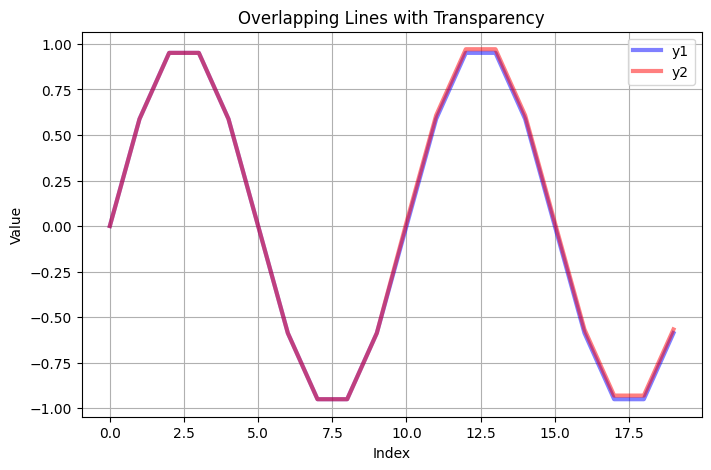

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Sample x values
x = np.arange(20)

# y1: base line
y1 = np.sin(x * 0.2 * np.pi)

# y2: identical to y1 for the first 10 points, slightly different afterward
y2 = y1.copy()
y2[10:] += 0.02  # small difference

# Plot both with transparency
plt.figure(figsize=(8, 5))
plt.plot(x, y1, color='blue', alpha=0.5, linewidth=3, label='y1')
plt.plot(x, y2, color='red', alpha=0.5, linewidth=3, label='y2')

# Add legend and axis labels
plt.title("Overlapping Lines with Transparency")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.show()


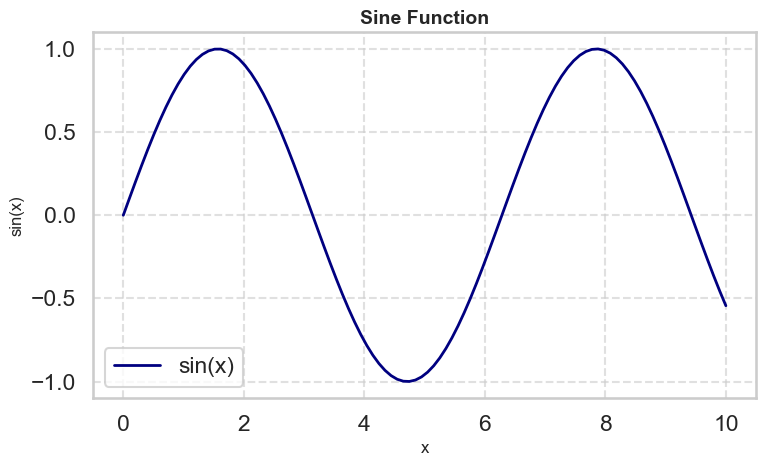

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Plot
sns.set(style='whitegrid', context='talk') 
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='sin(x)', color='navy', linewidth=2)

# Styling
plt.title('Sine Function', fontsize=14, fontweight='bold')
plt.xlabel('x', fontsize=12)
plt.ylabel('sin(x)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('sine_plot.pdf', dpi=300)  # or .png, .svg, etc.

plt.show()


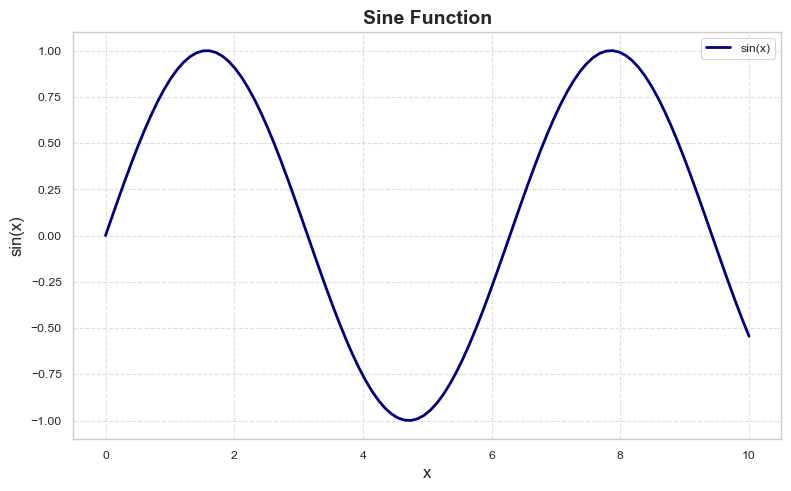

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Plot
sns.set(style='whitegrid', context='paper') 
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='sin(x)', color='navy', linewidth=2)

# Styling
plt.title('Sine Function', fontsize=14, fontweight='bold')
plt.xlabel('x', fontsize=12)
plt.ylabel('sin(x)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('sine_plot.pdf', dpi=300)  # or .png, .svg, etc.

plt.show()


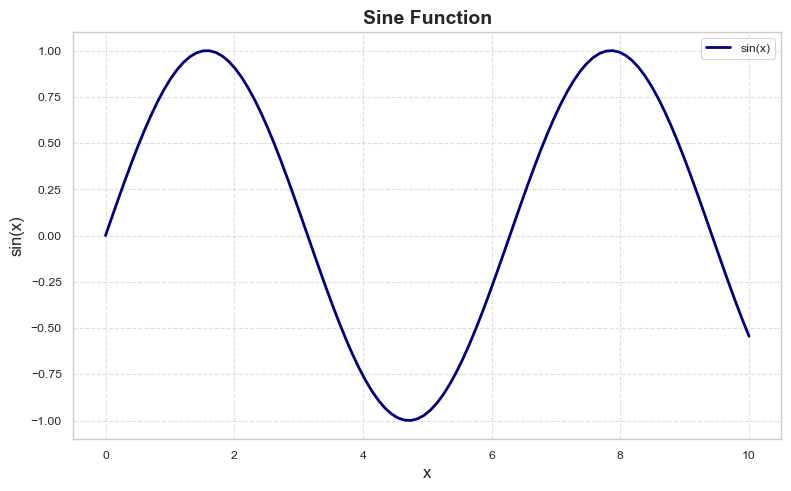

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Plot
sns.set(style='whitegrid', context='paper') 
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='sin(x)', color='navy', linewidth=2)

# Styling
plt.title('Sine Function', fontsize=14, fontweight='bold')
plt.xlabel('x', fontsize=12)
plt.ylabel('sin(x)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('sine_plot.pdf', dpi=300)  # or .png, .svg, etc.

plt.show()


In [2]:
file_path = 'DailyDelhiClimateTrain.csv'
data = pd.read_csv(file_path)
df = pd.DataFrame(data)
# Ensure 'date' is a datetime object
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index if needed (optional)
df.set_index('date', inplace=True)

In [4]:
lag = 100
step = 2
end = 200
TiOT_lib.eTiOT(df[['meantemp', 'humidity']].iloc[:end:step].to_numpy(), df[['meantemp' , 'humidity']].iloc[lag:lag+end:step].to_numpy())

(0.6082386983079056,
 array([[2.43383773e-051, 8.84002537e-038, 8.09708844e-017, ...,
         0.00000000e+000, 1.63126985e-205, 1.90718402e-205],
        [4.58201990e-067, 1.94867905e-052, 2.25040482e-028, ...,
         0.00000000e+000, 1.32206405e-203, 3.33446708e-202],
        [8.39216790e-069, 3.32415656e-054, 4.61660401e-030, ...,
         0.00000000e+000, 1.30237957e-199, 3.88268242e-198],
        ...,
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.79323934e-039, 5.74033263e-003, 3.72763351e-004],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.26098093e-066, 2.86099766e-009, 4.27388925e-005],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         3.62921294e-047, 1.20498663e-003, 6.46758973e-003]]),
 0.4308297411745447)

In [3]:
lag = 100
step = 2
end = 200
TiOT_lib.eTiOT(df[['meantemp', 'humidity']].iloc[:end:step].to_numpy(), df[['meantemp' , 'humidity']].iloc[lag:lag+end:step].to_numpy())

branch else
branch else


(0.6082386983079056,
 array([[2.43383773e-051, 8.84002537e-038, 8.09708844e-017, ...,
         0.00000000e+000, 1.63126985e-205, 1.90718402e-205],
        [4.58201990e-067, 1.94867905e-052, 2.25040482e-028, ...,
         0.00000000e+000, 1.32206405e-203, 3.33446708e-202],
        [8.39216790e-069, 3.32415656e-054, 4.61660401e-030, ...,
         0.00000000e+000, 1.30237957e-199, 3.88268242e-198],
        ...,
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.79323934e-039, 5.74033263e-003, 3.72763351e-004],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.26098093e-066, 2.86099766e-009, 4.27388925e-005],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         3.62921294e-047, 1.20498663e-003, 6.46758973e-003]]),
 0.4308297411745447)

In [ ]:
lag = 100
step = 2
end = 200
TiOT_lib.eTiOT(df[['meantemp', 'humidity']].iloc[:end:step], df[['meantemp' , 'humidity']].iloc[lag:lag+end:step])

KeyError: 0

In [5]:
TiOT_lib.multi_dimension_reshape(df[['meantemp', 'humidity']].iloc[:end:step].to_numpy())

array([[10.        , 84.5       ],
       [ 7.16666667, 87.        ],
       [ 6.        , 86.83333333],
       [ 7.        , 78.6       ],
       [14.        , 51.25      ],
       [15.71428571, 51.28571429],
       [15.83333333, 75.16666667],
       [14.71428571, 71.85714286],
       [16.5       , 80.83333333],
       [12.5       , 76.66666667],
       [11.2       , 77.        ],
       [14.        , 60.16666667],
       [12.25      , 67.        ],
       [12.85714286, 65.57142857],
       [14.125     , 65.5       ],
       [16.2       , 65.6       ],
       [16.28571429, 77.57142857],
       [17.42857143, 74.28571429],
       [16.66666667, 71.33333333],
       [14.        , 70.42857143],
       [15.25      , 71.5       ],
       [15.33333333, 70.33333333],
       [17.33333333, 63.83333333],
       [14.42857143, 92.71428571],
       [15.6       , 78.4       ],
       [17.71428571, 74.71428571],
       [20.5       , 65.625     ],
       [16.85714286, 78.85714286],
       [17.85714286,

In [6]:
df[['meantemp', 'humidity']].iloc[:end:step].to_numpy()

array([[10.        , 84.5       ],
       [ 7.16666667, 87.        ],
       [ 6.        , 86.83333333],
       [ 7.        , 78.6       ],
       [14.        , 51.25      ],
       [15.71428571, 51.28571429],
       [15.83333333, 75.16666667],
       [14.71428571, 71.85714286],
       [16.5       , 80.83333333],
       [12.5       , 76.66666667],
       [11.2       , 77.        ],
       [14.        , 60.16666667],
       [12.25      , 67.        ],
       [12.85714286, 65.57142857],
       [14.125     , 65.5       ],
       [16.2       , 65.6       ],
       [16.28571429, 77.57142857],
       [17.42857143, 74.28571429],
       [16.66666667, 71.33333333],
       [14.        , 70.42857143],
       [15.25      , 71.5       ],
       [15.33333333, 70.33333333],
       [17.33333333, 63.83333333],
       [14.42857143, 92.71428571],
       [15.6       , 78.4       ],
       [17.71428571, 74.71428571],
       [20.5       , 65.625     ],
       [16.85714286, 78.85714286],
       [17.85714286,

In [4]:
lag = 100
step = 1
end = 10
res, P, P2  = TiOT_lib.TiOT(df['meantemp'].iloc[:end:step].to_numpy(), df['meantemp'].iloc[lag:lag+end:step].to_numpy(), detail_mode=True)

In [8]:
x = res.x

In [9]:
u = x[:int(len(x) / 2)]
v = x[int(len(x) / 2):-1]
w = x[-1]

In [10]:
C = TiOT_lib.costmatrix1(df['meantemp'].iloc[:end:step].to_numpy(), df['meantemp'].iloc[lag:lag+end:step].to_numpy(), w = w)

In [13]:
lam = np.zeros_like(C)
for i in range(len(C[0])):
    for j in range(len(C)):
        lam[i,j] = C[i,j] + u[i] + v[j]

In [14]:
np.count_nonzero(lam)

87

In [15]:
np.count_nonzero(P)

10

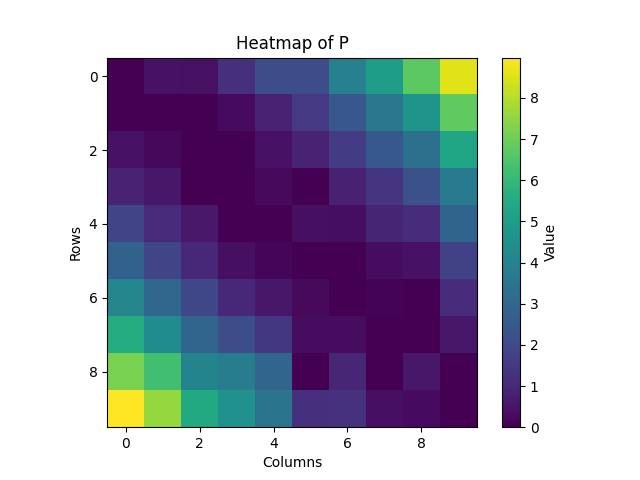

In [ ]:
plt.figure()
plt.imshow(lam, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap of lambda')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

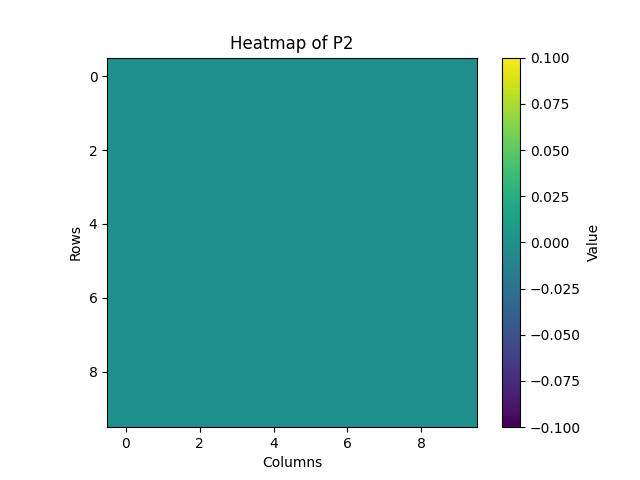

In [4]:
plt.figure()
plt.imshow(P2, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap of P2')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [6]:
P2

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

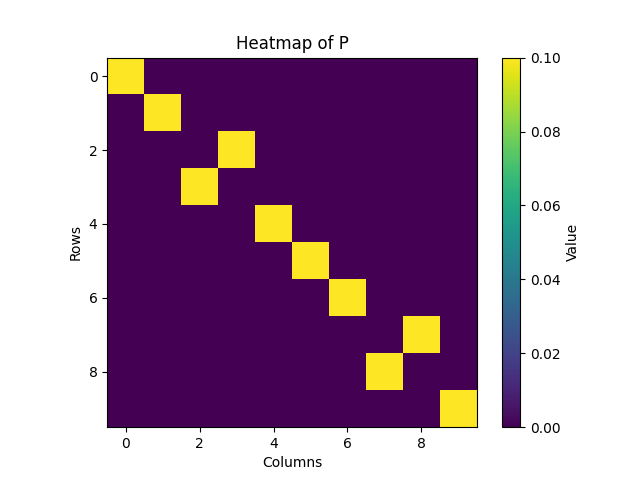

In [5]:
plt.figure()
plt.imshow(P, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap of P')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

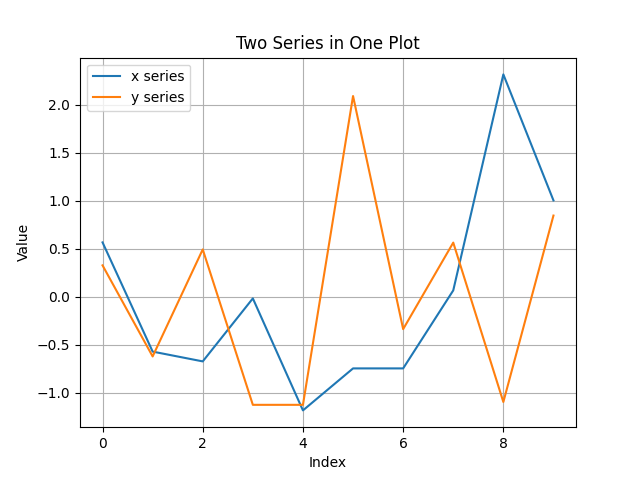

In [5]:
plt.figure()
a , b = TiOT_lib.normalization(df['meantemp'].iloc[:end:step].to_numpy(), df['meantemp'].iloc[lag:lag+end:step].to_numpy())
plt.plot(a, label='x series')
plt.plot( b, label='y series')

# Add labels and legend
plt.title('Two Series in One Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

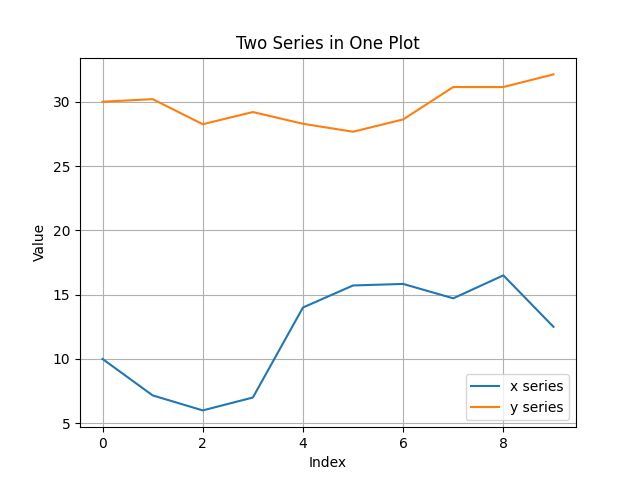

In [13]:
plt.figure()
plt.plot(df['meantemp'].iloc[:end:step].to_numpy(), label='x series')
plt.plot(df['meantemp'].iloc[lag:lag+end:step].to_numpy(), label='y series')

# Add labels and legend
plt.title('Two Series in One Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
P

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [15]:
np.count_nonzero(lam == 0)

66

In [1]:
import numpy as np
import pulp

def compute_optimal_transport(u, v, C, a, b, epsilon=1e-6):
    """
    Compute optimal transport plan P from dual variables u and v.
    
    Args:
        u: Dual variables for rows (1D array)
        v: Dual variables for columns (1D array)
        C: Cost matrix (2D array)
        a: Source marginals (1D array)
        b: Target marginals (1D array)
        epsilon: Tolerance for numerical comparisons
        
    Returns:
        P: Optimal transport plan matrix (2D array)
    """
    n, m = C.shape
    P = np.zeros((n, m))
    
    # Identify support set S = {(i,j) | u[i] + v[j] ≈ C[i,j]}
    S = [(i, j) for i in range(n) for j in range(m) 
         if abs(u[i] + v[j] - C[i,j]) < epsilon]
    
    # Create LP problem
    prob = pulp.LpProblem("OptimalTransport", pulp.LpMinimize)
    
    # Create variables only for pairs in S
    variables = pulp.LpVariable.dicts("P", S, lowBound=0)
    
    # Dummy objective (since we already know optimality)
    prob += 0  # We just need a feasible solution
    
    # Add row constraints
    for i in range(n):
        row_vars = [variables[(i, j)] for j in range(m) if (i, j) in S]
        if row_vars:
            prob += pulp.lpSum(row_vars) == a[i]
    
    # Add column constraints
    for j in range(m):
        col_vars = [variables[(i, j)] for i in range(n) if (i, j) in S]
        if col_vars:
            prob += pulp.lpSum(col_vars) == b[j]
    
    # Solve LP
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Extract solution
    for (i, j) in S:
        P[i, j] = pulp.value(variables[(i, j)])
    
    return P

# Example usage
if __name__ == "__main__":
    # Example problem parameters
    C = np.array([[1, 2], [3, 4]])  # Cost matrix
    a = np.array([0.5, 0.5])        # Source distribution
    b = np.array([0.5, 0.5])        # Target distribution
    
    # Example dual solution (these would normally come from solving the dual problem)
    u = np.array([0.0, 0.0])       # Dual variables for rows
    v = np.array([1.0, 2.0])       # Dual variables for columns
    
    # Compute optimal transport plan
    P = compute_optimal_transport(u, v, C, a, b)
    
    print("Optimal transport plan:")
    print(P)

Optimal transport plan:
[[0.5 0.5]
 [0.  0. ]]
